In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [11]:
data = pd.read_csv('insurance.csv')
data.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [12]:
df_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])
df_encoded = df_encoded.astype(int)
df_encoded

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,1,0,0,1,0,0,0,1
1,18,33,1,1725,0,1,1,0,0,0,1,0
2,28,33,3,4449,0,1,1,0,0,0,1,0
3,33,22,0,21984,0,1,1,0,0,1,0,0
4,32,28,0,3866,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30,3,10600,0,1,1,0,0,1,0,0
1334,18,31,0,2205,1,0,1,0,1,0,0,0
1335,18,36,0,1629,1,0,1,0,0,0,1,0
1336,21,25,0,2007,1,0,1,0,0,0,0,1


In [15]:
df_encoded['region_north'] = data['region'].isin(['northeast', 'northwest']).astype(int)
df_encoded['region_west'] = data['region'].isin(['northwest', 'southwest']).astype(int)
df_encoded.head()


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,region_north,region_west
0,19,27,0,16884,1,0,0,1,0,0,0,1,0,1
1,18,33,1,1725,0,1,1,0,0,0,1,0,0,0
2,28,33,3,4449,0,1,1,0,0,0,1,0,0,0
3,33,22,0,21984,0,1,1,0,0,1,0,0,1,1
4,32,28,0,3866,0,1,1,0,0,1,0,0,1,1


In [16]:
# Drop extra columns
df_encoded.drop(['sex_female', 'smoker_no', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'], axis=1, inplace=True)
df_encoded


,age,bmi,children,charges,sex_male,smoker_yes,region_north,region_west
0,19,27,0,16884,0,1,0,1
1,18,33,1,1725,1,0,0,0
2,28,33,3,4449,1,0,0,0
3,33,22,0,21984,1,0,1,1
4,32,28,0,3866,1,0,1,1
...,...,...,...,...,...,...,...,...
1333,50,30,3,10600,1,0,1,1
1334,18,31,0,2205,0,0,1,0
1335,18,36,0,1629,0,0,0,0
1336,21,25,0,2007,0,0,0,1


In [18]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0,27.0,39.0,51.00,64.0
bmi,1338.0,30.169656,6.119875,15.0,26.0,30.0,34.00,53.0
children,1338.0,1.094918,1.205493,0.0,0.0,1.0,2.00,5.0
charges,1338.0,13269.928999,12110.012755,1121.0,4740.0,9381.5,16639.25,63770.0
sex_male,1338.0,0.505232,0.500160,0.0,0.0,1.0,1.00,1.0
smoker_yes,1338.0,0.204783,0.403694,0.0,0.0,0.0,0.00,1.0
region_north,1338.0,0.485052,0.499963,0.0,0.0,0.0,1.00,1.0
region_west,1338.0,0.485800,0.499985,0.0,0.0,0.0,1.00,1.0


In [21]:
df_encoded.isnull().sum()

age             0
bmi             0
children        0
charges         0
sex_male        0
smoker_yes      0
region_north    0
region_west     0
dtype: int64

In [23]:
df_encoded.corr()

,age,bmi,children,charges,sex_male,smoker_yes,region_north,region_west
age,1.000000,0.108437,0.042469,0.299009,-0.020856,-0.025019,0.001772,0.008245
bmi,0.108437,1.000000,0.011097,0.196188,0.046503,0.001669,-0.237875,-0.122531
children,0.042469,0.011097,1.000000,0.067999,0.017163,0.007673,0.001735,0.040086
charges,0.299009,0.196188,0.067999,1.000000,0.057293,0.787251,-0.028798,-0.071314
sex_male,-0.020856,0.046503,0.017163,0.057293,1.000000,0.076185,-0.011651,-0.013162
smoker_yes,-0.025019,0.001669,0.007673,0.787251,0.076185,1.000000,-0.029292,-0.063400
region_north,0.001772,-0.237875,0.001735,-0.028798,-0.011651,-0.029292,1.000000,0.029071
region_west,0.008245,-0.122531,0.040086,-0.071314,-0.013162,-0.063400,0.029071,1.000000


In [26]:
df_encoded.duplicated().sum()

18

# K-Nearest Neighbors (KNN)

In [534]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [535]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_north,region_west
560,46,19,2,0,0,1,1
1285,47,24,0,0,0,1,0
1142,52,24,0,0,0,0,0
969,39,34,5,0,0,0,0
486,54,21,3,0,0,1,1


In [536]:
y_train.head()

560      9193
1285     8534
1142    27117
969      8596
486     12475
Name: charges, dtype: int32

In [537]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)

In [538]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [539]:
knn_model.n_neighbors

5

In [540]:
knn_model.effective_metric_

'euclidean'

## KNN Prediction

In [541]:
y_pred = knn_model.predict(X_test)
y_pred.shape

(268,)

In [542]:
rmse_first = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_first

11024.675707553324

In [543]:
r2_score(y_test, y_pred)

0.21710329672110362

In [544]:
RMSE = [] 

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    RMSE.append(rmse) 
    print("k =" , k , "RMSE Value: ", rmse)

k = 1 RMSE Value:  949.949910140372
k = 2 RMSE Value:  6500.519496943316
k = 3 RMSE Value:  7952.455732851952
k = 4 RMSE Value:  8721.378305912898
k = 5 RMSE Value:  9155.767048767117
k = 6 RMSE Value:  9510.795340577899
k = 7 RMSE Value:  9719.65080923692
k = 8 RMSE Value:  9891.726231412187
k = 9 RMSE Value:  10014.26273723024
k = 10 RMSE Value:  10009.977657882113


## KNN Model Tuning

In [545]:
from sklearn.model_selection import GridSearchCV

In [546]:
knn_params = {'n_neighbors': np.arange(1,50,1)}
knn = KNeighborsRegressor()

In [547]:
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10)
knn_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [548]:
knn_cv_model.best_params_["n_neighbors"]

23

In [549]:
RMSE = [] 
RMSE_CV = []
for k in range(25):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    rmse_cv = np.sqrt(-1*cross_val_score(knn_model, X_train, y_train, cv=10, 
                                         scoring = "neg_mean_squared_error").mean())
    RMSE.append(rmse) 
    RMSE_CV.append(rmse_cv)
    print("k =" , k , "RMSE Value: ", rmse, "RMSE_CV Value: ", rmse_cv )


k = 1 RMSE Value:  949.949910140372 RMSE_CV Value:  13177.41321136249
k = 2 RMSE Value:  6500.519496943316 RMSE_CV Value:  11858.46647712168
k = 3 RMSE Value:  7952.455732851952 RMSE_CV Value:  11598.077176824814
k = 4 RMSE Value:  8721.378305912898 RMSE_CV Value:  11579.763915011172
k = 5 RMSE Value:  9155.767048767117 RMSE_CV Value:  11501.473266240984
k = 6 RMSE Value:  9510.795340577899 RMSE_CV Value:  11460.983970578518
k = 7 RMSE Value:  9719.65080923692 RMSE_CV Value:  11315.273769371843
k = 8 RMSE Value:  9891.726231412187 RMSE_CV Value:  11209.874499699228
k = 9 RMSE Value:  10014.26273723024 RMSE_CV Value:  11203.48518636771
k = 10 RMSE Value:  10009.977657882113 RMSE_CV Value:  11182.999084509493
k = 11 RMSE Value:  10078.535738401237 RMSE_CV Value:  11194.645782514433
k = 12 RMSE Value:  10205.821641942555 RMSE_CV Value:  11164.162716136057
k = 13 RMSE Value:  10287.717611660752 RMSE_CV Value:  11162.470984489837
k = 14 RMSE Value:  10331.744917564149 RMSE_CV Value:  11162.

In [550]:
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"])
#knn_tuned = KNeighborsRegressor(n_neighbors = 23)


In [551]:
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=23)

In [552]:
rmse_knn = np.sqrt(mean_squared_error(y_test, knn_tuned.predict(X_test)))
rmse_knn

11399.3747096205

In [553]:
r2_knn = r2_score(y_test, knn_tuned.predict(X_test))
r2_knn

0.16298184779019975

# Support Vector Regression (SVR)

In [517]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [518]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [519]:
from sklearn.svm import SVR
svr_model = SVR(kernel="linear", C=100, gamma="auto")
svr_model.fit(X_train_scaled, y_train)

SVR(C=100, gamma='auto', kernel='linear')


# SVR Prediction

In [520]:
y_pred_train = svr_model.predict(X_train_scaled)
y_pred_test = svr_model.predict(X_test_scaled)

In [521]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [522]:
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train RMSE: 7523.3695465202
Test RMSE: 7358.368462966521
Train R^2: 0.6078457695418638
Test R^2: 0.6512326037416865


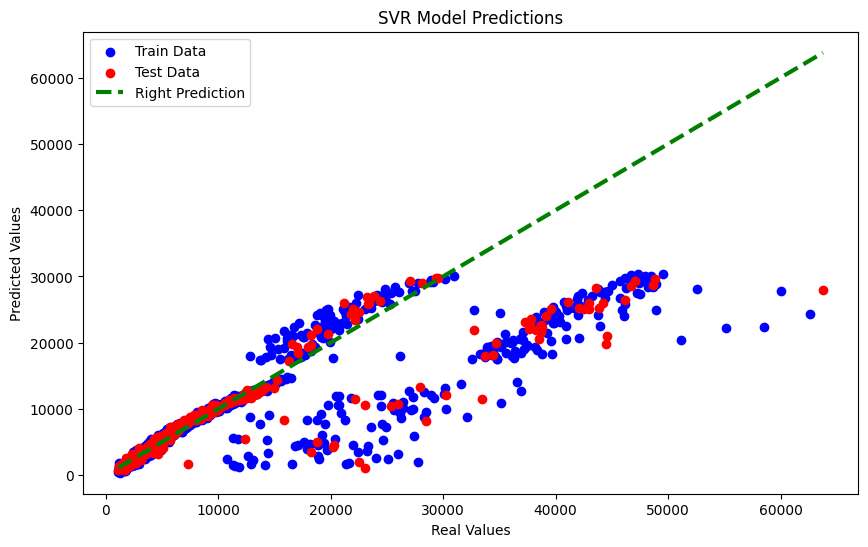

In [523]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, color="blue", label="Train Data")
plt.scatter(y_test, y_pred_test, color="red", label="Test Data")
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("SVR Model Predictions")
plt.legend()
plt.plot([min(y), max(y)], [min(y), max(y)], color='green', linestyle='--', lw=3, label='Right Prediction')
plt.legend()
plt.show()

In [524]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression()
lm_model.fit(X_train_scaled, y_train)
y_pred_train_lm = lm_model.predict(X_train_scaled)
y_pred_test_lm = lm_model.predict(X_test_scaled)
print("y = {0} + {1} x".format(lm_model.intercept_, lm_model.coef_[0]))

train_rmse_lm = np.sqrt(mean_squared_error(y_train, y_pred_train_lm))
test_rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_test_lm))
train_r2_lm = r2_score(y_train, y_pred_train_lm)
test_r2_lm = r2_score(y_test, y_pred_test_lm)

y = 13345.596261682243 + 3617.50798525406 x


In [526]:
print("\nLinear Regression Model:")
print("Train RMSE:", train_rmse_lm)
print("Test RMSE:", test_rmse_lm)
print("Train R^2:", train_r2_lm)
print("Test R^2:", test_r2_lm)


Linear Regression Model:
Train RMSE: 6106.855622934312
Test RMSE: 5796.220881266898
Train R^2: 0.7416149273913606
Test R^2: 0.7835973017419022


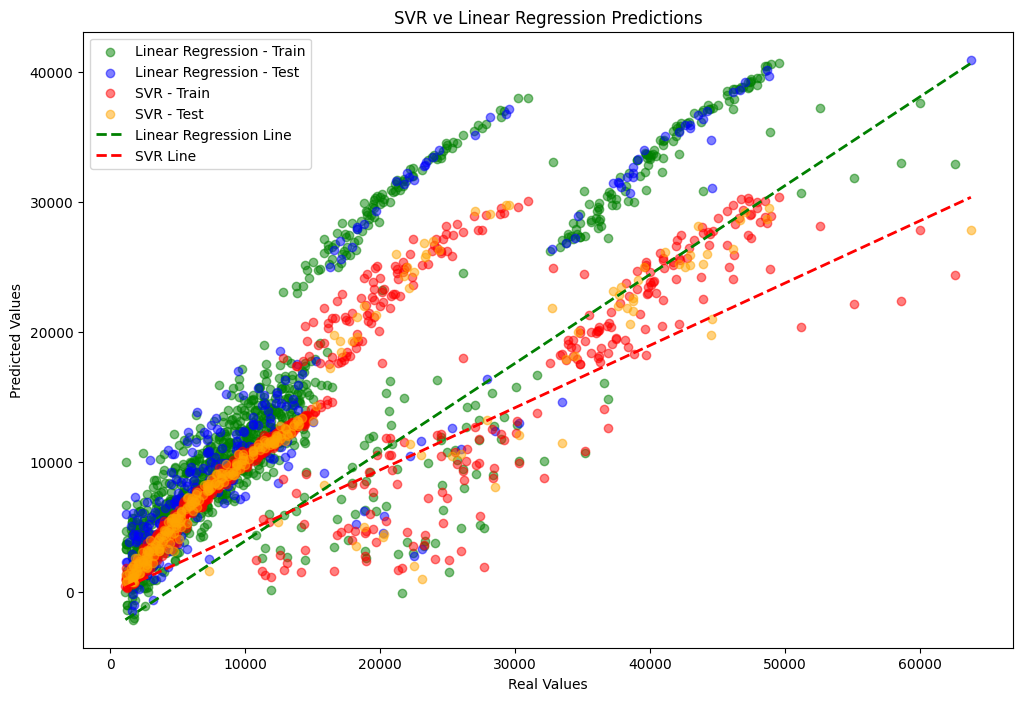

In [527]:
plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(y_train, y_pred_train_lm, color='g', label="Linear Regression - Train", alpha=0.5)
plt.scatter(y_test, y_pred_test_lm, color='b', label="Linear Regression - Test", alpha=0.5)
plt.scatter(y_train, y_pred_train, color='r', label="SVR - Train", alpha=0.5)
plt.scatter(y_test, y_pred_test, color='orange', label="SVR - Test", alpha=0.5)

# Linear Regression modelinin tahminlerinin çizgisi
plt.plot([min(y), max(y)], [min(y_pred_train_lm), max(y_pred_train_lm)], color='green', linestyle='--', lw=2, label="Linear Regression Line")

# SVR modelinin tahminlerinin çizgisi
plt.plot([min(y), max(y)], [min(y_pred_train), max(y_pred_train)], color='red', linestyle='--', lw=2, label="SVR Line")

plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("SVR ve Linear Regression Predictions")
plt.legend()
plt.show()

## SVR Estimation

In [222]:
print ("y = {0} + {1} x".format(svr_model.intercept_, svr_model.coef_)) 

y = [10533.53494539] + [[3654.30770053  279.69805594  487.2050138  -199.95190206 6681.80921652
   239.23236265 -102.07672991]] x


In [223]:
y_pred = svr_model.predict(X_test_scaled)

In [226]:
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_svr

7358.368462966521

In [227]:
r2_svr= r2_score(y_test, y_pred)
r2_svr

0.6512326037416865

## SVR Model Tuning

In [228]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly']}
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.105 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.161 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.065 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.098 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=1, kernel=linear;, score=-0.045 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.112 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.168 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.073 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.104 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.053 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.068 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

In [229]:
y_pred_tuned = grid.predict(X_test_scaled)


In [232]:
rmse_svr_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_svr_tuned = r2_score(y_test, y_pred_tuned)

In [233]:
print("After Tuning Test RMSE:", rmse_svr_tuned)
print("After Tuning Test R^2:", r2_svr_tuned)

After Tuning Test RMSE: 4688.708758799891
After Tuning Test R^2: 0.8583947576312


# Multiple Layer Perceptron (MLP)

In [238]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [239]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [240]:
from sklearn.neural_network import MLPRegressor

In [241]:
mlp_model = MLPRegressor(hidden_layer_sizes = (100,20)).fit(X_train_scaled, y_train)

In [242]:
mlp_model

MLPRegressor(hidden_layer_sizes=(100, 20))

In [243]:
mlp_model.n_layers_

4

In [244]:
mlp_model.hidden_layer_sizes

(100, 20)

## MLP Estimation

In [245]:
y_pred = mlp_model.predict(X_test_scaled)

In [246]:
rmse_mlp=np.sqrt(mean_squared_error(y_test, y_pred))
rmse_mlp

6391.546541709743

In [247]:
r2_score_mlp=r2_score(y_test, y_pred)
r2_score_mlp

0.7368612976337243

## MLP Tuning

In [248]:
mlp_params = {'alpha': [0.1, 0.01,0.02,0.005],
             'hidden_layer_sizes': [(20,20),(100,50,150),(300,200,150)],
             'activation': ['relu','logistic']}

In [249]:
mlp_cv_model = GridSearchCV(mlp_model, mlp_params, cv = 10, n_jobs=-1)

In [250]:
mlp_cv_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=MLPRegressor(hidden_layer_sizes=(100, 20)),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005],
                         'hidden_layer_sizes': [(20, 20), (100, 50, 150),
                                                (300, 200, 150)]})

In [251]:
mlp_cv_model.best_params_

{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (300, 200, 150)}

In [252]:
mlp_tuned = MLPRegressor(alpha = 0.01, hidden_layer_sizes = (300,200,150))

In [253]:
mlp_tuned.fit(X_train_scaled, y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(300, 200, 150))

In [254]:
y_pred = mlp_tuned.predict(X_test_scaled)

In [255]:
rmse_mlp =np.sqrt(mean_squared_error(y_test, y_pred))
rmse_mlp

4706.800599549339

In [256]:
r2_mlp = r2_score(y_test, y_pred)
r2_mlp

0.8572998539824583

# CART

In [274]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)


df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [275]:
cart_model = DecisionTreeRegressor(min_samples_split = 2)

In [276]:
X_train = pd.DataFrame(X_train["age"])
X_test = pd.DataFrame(X_test["age"])

In [278]:
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

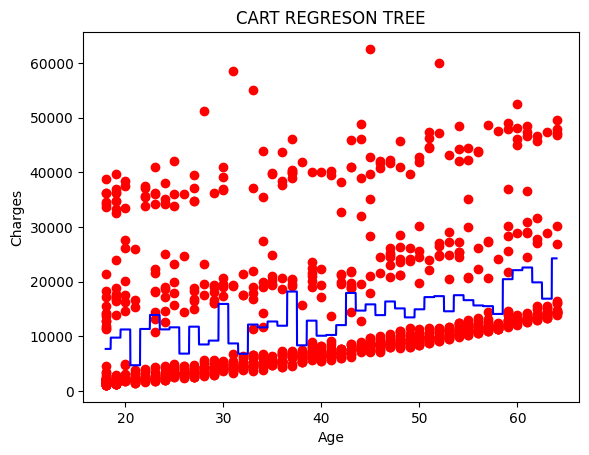

In [279]:
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1))  
plt.scatter(X_train, y_train, color = 'red') 
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  
plt.title('CART REGRESON TREE')  
plt.xlabel('Age') 
plt.ylabel('Charges') ;

In [280]:
from skompiler import skompile

# CART Model Prediction

In [283]:
print(skompile(cart_model.predict).to('python/code'))

((((7709.180327868852 if x[0] <= 18.5 else 9773.0 if x[0] <= 19.5 else 
    11266.958333333334) if x[0] <= 20.5 else 4723.666666666667) if x[0] <= 
    21.5 else (((((11360.842105263158 if x[0] <= 22.5 else 
    13920.57142857143) if x[0] <= 23.5 else 11280.26923076923 if x[0] <= 
    24.5 else 11658.95) if x[0] <= 25.5 else 6847.421052631579 if x[0] <= 
    26.5 else 11778.416666666666 if x[0] <= 27.5 else 8522.857142857143 if 
    x[0] <= 28.5 else 9229.681818181818) if x[0] <= 29.5 else 
    15939.29411764706) if x[0] <= 30.5 else 8712.15 if x[0] <= 31.5 else 
    6822.75) if x[0] <= 32.5 else (((12167.238095238095 if x[0] <= 33.5 else
    11646.52380952381) if x[0] <= 34.5 else 12725.05 if x[0] <= 35.5 else 
    11950.714285714286) if x[0] <= 36.5 else 18203.0) if x[0] <= 37.5 else 
    8365.272727272728 if x[0] <= 38.5 else 12879.190476190477 if x[0] <= 
    39.5 else (10121.904761904761 if x[0] <= 40.5 else 10263.09090909091) if
    x[0] <= 41.5 else 12065.318181818182) if x[0] <

In [284]:
y_pred =cart_model.predict(X_test)

In [285]:
np.sqrt(mean_squared_error(y_test, y_pred))

11916.853395538335

## CART Model Tuning

In [287]:
cart_model = DecisionTreeRegressor()
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

In [288]:
np.sqrt(mean_squared_error(y_test, y_pred))

11916.853395538335

In [289]:
cart_params = {"min_samples_split": range(2,100),
               "max_leaf_nodes": range(2,10)}

In [290]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10)

In [291]:
cart_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 100)})

In [292]:
cart_cv_model.best_params_

{'max_leaf_nodes': 3, 'min_samples_split': 2}

In [293]:
cart_tuned = DecisionTreeRegressor(max_leaf_nodes = 3, min_samples_split = 2)

In [294]:
cart_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=3)

In [296]:
y_pred = cart_tuned.predict(X_test)

In [297]:
rmse_cart = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_cart

11764.218023279045

In [298]:
r2_cart = r2_score(y_test, y_pred)
r2_cart

0.10854598267398452

# Bagged Trees Regression

In [310]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [311]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [312]:
bag_model.n_estimators

10

In [313]:
bag_model.estimators_samples_

[array([985, 548, 845, ..., 767, 266, 936]),
 array([ 831,  228,  807, ..., 1055,  373,  662]),
 array([ 510,  550, 1010, ...,  348,  484,   26]),
 array([775, 641, 571, ..., 564, 479, 404]),
 array([490, 150, 256, ..., 152, 404, 787]),
 array([421, 244, 108, ..., 126,  27, 136]),
 array([134, 752, 379, ..., 109, 383, 471]),
 array([250, 531, 994, ..., 509, 468, 130]),
 array([730, 785, 175, ..., 606, 823, 329]),
 array([ 935,  931,  214, ..., 1048,  568,  956])]

In [314]:
bag_model.estimators_features_

[array([2, 2, 6, 0, 0, 5, 4]),
 array([6, 4, 1, 0, 3, 2, 4]),
 array([0, 1, 2, 6, 5, 0, 5]),
 array([0, 1, 2, 1, 5, 0, 6]),
 array([4, 4, 3, 2, 5, 0, 5]),
 array([4, 3, 4, 2, 0, 4, 3]),
 array([4, 1, 0, 0, 1, 4, 4]),
 array([1, 5, 4, 1, 6, 3, 4]),
 array([4, 5, 1, 6, 3, 0, 2]),
 array([5, 4, 6, 3, 4, 6, 2])]

# BAG Prediction

In [315]:
y_pred = bag_model.predict(X_test)

In [316]:
np.sqrt(mean_squared_error(y_test, y_pred))

6029.176961130608

In [322]:
r2_score(y_test, y_pred)

0.765852848279059

## BAG Tuning

In [323]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [324]:
bag_params = {"n_estimators": range(2,20)}

In [325]:
bag_cv_model_grid = GridSearchCV(bag_model, bag_params, cv = 10, n_jobs=-1)
bag_cv_model_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             n_jobs=-1, param_grid={'n_estimators': range(2, 20)})

In [326]:
bag_cv_model_random = RandomizedSearchCV(bag_model, bag_params, cv = 10)
bag_cv_model_random.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
                   param_distributions={'n_estimators': range(2, 20)})

In [328]:
print("Grid", bag_cv_model_grid.best_params_)
print('Random:', bag_cv_model_random.best_params_)

Grid {'n_estimators': 13}
Random: {'n_estimators': 12}


In [329]:
bag_grid_tuned = BaggingRegressor( n_estimators = 13)

In [330]:
bag_grid_tuned.fit(X_train, y_train)

BaggingRegressor(n_estimators=13)

In [331]:
y_pred = bag_grid_tuned.predict(X_test)

In [332]:
rmse_bagged = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_bagged

5017.387204407408

In [333]:
r2_bagged = r2_score(y_test, y_pred)
r2_bagged

0.8378458555550868

# Random Forest

In [334]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [335]:
from sklearn.ensemble import RandomForestRegressor

In [336]:
rf_model = RandomForestRegressor(random_state = 42)

In [337]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# RF Prediction

In [338]:
y_pred = rf_model.predict(X_test)

In [339]:
np.sqrt(mean_squared_error(y_test, y_pred))

4710.158457559483

In [340]:
r2_score(y_test, y_pred)

0.8570961751826578

# RF Tuning

In [341]:
rf_params = {'max_depth': list(range(5,10)),
            'max_features': [5],
            'n_estimators' : [10,100,1000,2000,5000]}

In [342]:
rf_model = RandomForestRegressor(random_state = 42)

In [343]:
rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1)

In [344]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [5],
                         'n_estimators': [10, 100, 1000, 2000, 5000]})

In [345]:
rf_cv_model.best_params_

{'max_depth': 5, 'max_features': 5, 'n_estimators': 1000}

In [346]:
rf_tuned = RandomForestRegressor(max_depth  = 5, max_features = 5, n_estimators =1000)

In [347]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1000)

In [348]:
y_pred = rf_tuned.predict(X_test)

In [349]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rf

4425.119385074203

In [350]:
r2_rf =r2_score(y_test,y_pred)
r2_rf

0.87386872050494

In [351]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

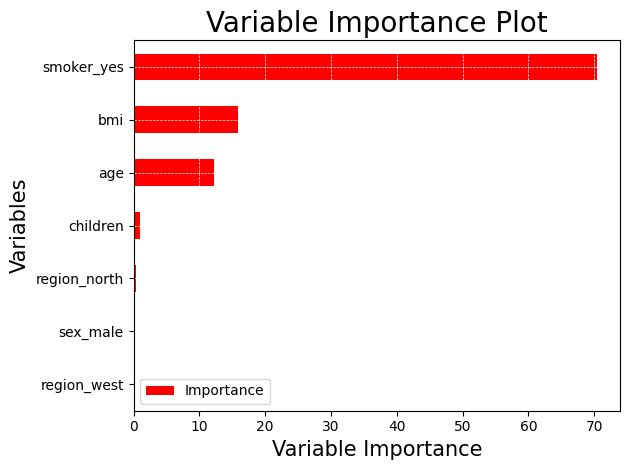

In [364]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Variable Importance",fontsize=15)
plt.ylabel("Variables", fontsize=15)
plt.title("Variable Importance Plot", fontsize=20)
#plt.gca().set_facecolor('yellow')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()

# Gradient Boosting Machines  (GBM)

In [365]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape) 
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [367]:
from sklearn.ensemble import GradientBoostingRegressor

In [368]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

# GBM Prediction

In [ ]:
y_pred = gbm_model.predict(X_test)


4373.749101381204

In [369]:
rmse_gbm =np.sqrt(mean_squared_error(y_test, y_pred))
rmse_gbm

4425.119385074203

# GBM Model Tuning

In [370]:
gbm_params = {
    'learning_rate': [0.005, 0.01, 0.02,0.05, 0.6],
    'max_depth': [1,2,3,4,5],
    'n_estimators': [200,300,400,500,600,700],
    'subsample': [0.6,0.75, 0.8],
}

In [371]:
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)
gbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 450 candidates, totalling 4500 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.6],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [200, 300, 400, 500, 600, 700],
                         'subsample': [0.6, 0.75, 0.8]},
             verbose=2)

In [373]:
gbm_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.6}

In [374]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.01,  
                                      max_depth = 3, 
                                      n_estimators = 400, 
                                      subsample = 0.6)

gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [375]:
y_pred = gbm_tuned.predict(X_test)


In [376]:
rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_gbm

4373.989206897355

In [378]:
r2_bgm = r2_score(y_test, y_pred)
r2_bgm

0.8767666565778782

In [379]:
Importance = pd.DataFrame({"Importance": gbm_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 1.0, 'Variable Importance Levels Graph')

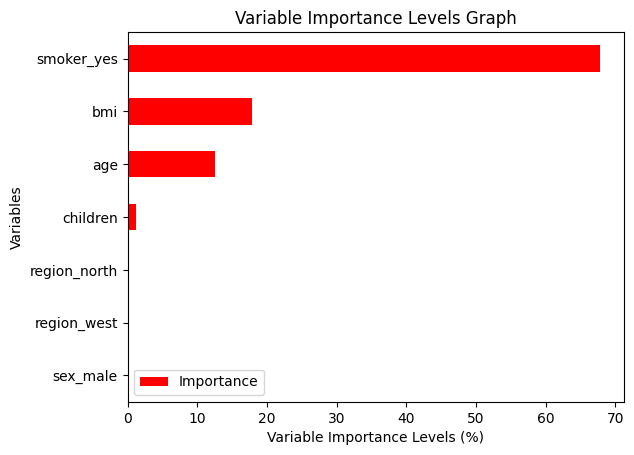

In [381]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Variable Importance Levels (%)")
plt.ylabel("Variables")
plt.title("Variable Importance Levels Graph")

# Extreme Gradient Boosting (XGBoost)

In [384]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape) 
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [387]:
#pip install xgboost
import xgboost as xgb

In [388]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)

In [389]:
from xgboost import XGBRegressor

In [390]:
xgb_model = XGBRegressor().fit(X_train, y_train)

# XGBoost Prediction

In [391]:
y_pred = xgb_model.predict(X_test)


In [392]:
np.sqrt(mean_squared_error(y_test, y_pred))

5057.535153449027

# XGBoost Tuning

In [394]:
xgb_grid = {
     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9], 
     'n_estimators': [100, 200, 300, 400, 500],
     'max_depth': [3, 4, 5, 6, 7],
     'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5]
}


In [395]:
xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 2)


xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 625 candidates, totalling 6250 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

In [396]:
xgb_cv.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 100}

In [398]:
xgb_grid_tuned = {
    'colsample_bytree': [0.9],  
    'n_estimators': [100],       
    'max_depth': [3],               
    'learning_rate': [0.05]     
}

In [399]:
xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid_tuned, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 2)


xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9], 'learning_rate': [0.05],
                         'max_depth': [3], 'n_estimators': [100]},
             verbose=2)

In [400]:
xgb_cv.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 100}

In [402]:
xgb_tuned = xgb_cv.fit(X_train,y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [405]:
y_pred = xgb_tuned.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_xgb

4399.485722025016

In [406]:
r2_xgb = r2_score(y_test,y_pred)
r2_xgb

0.8753257849769358

# Light Gradient Boosting Machine (Light GBM)

In [407]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape) 
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [409]:
#pip install lightgbm
from lightgbm import LGBMRegressor

In [410]:
lgbm = LGBMRegressor()
lgbm_model = lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 7
[LightGBM] [Info] Start training from score 13345.596262


# Light GBM Prediction

In [411]:
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)

In [412]:
np.sqrt(mean_squared_error(y_test, y_pred))

4558.585057948897

In [413]:
r2_score(y_test, y_pred)

0.8661455103385216

# Light GBM Tuning

In [414]:
lgbm_grid = {
    'colsample_bytree': [0.5, 0.9, 1],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [40, 100, 200, 500],
    'max_depth': [2,3,4,5,6] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 2)

In [415]:
lgbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 7
[LightGBM] [Info] Start training from score 13345.596262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.9, 1],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [40, 100, 200, 500]},
             verbose=2)

In [416]:
lgbm_cv_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 500}

In [417]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.01, 
                           max_depth = 3, 
                           n_estimators = 500,
                          colsample_bytree = 1,
                          num_leaves=6)

lgbm_tuned = lgbm_tuned.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 7
[LightGBM] [Info] Start training from score 13345.596262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

# Light GBM Prediction

In [418]:
y_pred = lgbm_tuned.predict(X_test)

In [419]:
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_lgbm

4372.62887213392

In [420]:
r2_lgbm = r2_score(y_test,y_pred)
r2_lgbm

0.876843297156937

# CatBoost

In [427]:
X = df_encoded.drop("charges", axis = 1)
y = df_encoded["charges"]
print("df_encoded", df_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42)
print("X_train", X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape) 
print("y_test",y_test.shape)

df_encoded (1338, 8)
X_train (1070, 7)
y_train (1070,)
X_test (268, 7)
y_test (268,)


In [428]:
from catboost import CatBoostRegressor

In [429]:
catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train)

Learning rate set to 0.041383
0:	learn: 11647.1846371	total: 863us	remaining: 863ms
1:	learn: 11278.6571863	total: 1.61ms	remaining: 802ms
2:	learn: 10950.1043813	total: 2.29ms	remaining: 762ms
3:	learn: 10624.7037453	total: 3.03ms	remaining: 754ms
4:	learn: 10301.4701046	total: 3.77ms	remaining: 751ms
5:	learn: 9999.7921542	total: 4.52ms	remaining: 749ms
6:	learn: 9738.2345008	total: 5.27ms	remaining: 747ms
7:	learn: 9467.9218497	total: 5.9ms	remaining: 732ms
8:	learn: 9208.4832535	total: 6.58ms	remaining: 724ms
9:	learn: 8960.2642201	total: 7.26ms	remaining: 719ms
10:	learn: 8740.4086543	total: 8.01ms	remaining: 721ms
11:	learn: 8510.4998347	total: 8.78ms	remaining: 723ms
12:	learn: 8293.8645846	total: 9.56ms	remaining: 726ms
13:	learn: 8107.0536234	total: 10.3ms	remaining: 724ms
14:	learn: 7908.9829109	total: 11.1ms	remaining: 729ms
15:	learn: 7708.6112968	total: 12ms	remaining: 736ms
16:	learn: 7518.5712737	total: 12.7ms	remaining: 733ms
17:	learn: 7343.9836402	total: 13.5ms	remain

243:	learn: 3824.1412453	total: 179ms	remaining: 554ms
244:	learn: 3823.0987671	total: 180ms	remaining: 554ms
245:	learn: 3822.6479127	total: 181ms	remaining: 553ms
246:	learn: 3822.2205015	total: 181ms	remaining: 552ms
247:	learn: 3821.0841222	total: 182ms	remaining: 552ms
248:	learn: 3820.4712000	total: 183ms	remaining: 551ms
249:	learn: 3819.0406404	total: 184ms	remaining: 551ms
250:	learn: 3815.5051157	total: 184ms	remaining: 550ms
251:	learn: 3814.4550632	total: 185ms	remaining: 549ms
252:	learn: 3813.9456475	total: 186ms	remaining: 548ms
253:	learn: 3812.0726999	total: 186ms	remaining: 547ms
254:	learn: 3811.7129194	total: 187ms	remaining: 546ms
255:	learn: 3804.7416519	total: 188ms	remaining: 546ms
256:	learn: 3804.5522781	total: 188ms	remaining: 544ms
257:	learn: 3804.3582034	total: 189ms	remaining: 543ms
258:	learn: 3804.1829708	total: 189ms	remaining: 541ms
259:	learn: 3802.7483646	total: 190ms	remaining: 541ms
260:	learn: 3801.8838581	total: 191ms	remaining: 540ms
261:	learn

# CatBoost Prediction

In [430]:
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4852.61704477347

In [431]:
r2_score(y_test, y_pred) 

0.8483212098237348

# CatBoost Tuning

In [432]:
catb_grid = {
    'iterations': [50,100,200,250],
    'learning_rate': [0.04, 0.05, 0.6],
    'depth': [1,2,3,4] }

In [434]:
catb = CatBoostRegressor()
catb_cv_model = GridSearchCV(catb, catb_grid, cv=10, n_jobs = -1, verbose = 2)

In [435]:
catb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


0:	learn: 11598.6755889	total: 609us	remaining: 121ms
1:	learn: 11178.3680417	total: 1.1ms	remaining: 109ms
2:	learn: 10772.0978871	total: 1.54ms	remaining: 101ms
3:	learn: 10368.3957257	total: 2ms	remaining: 98.2ms
4:	learn: 9998.9238393	total: 2.45ms	remaining: 95.4ms
5:	learn: 9632.3138796	total: 2.91ms	remaining: 94ms
6:	learn: 9310.3863498	total: 3.36ms	remaining: 92.7ms
7:	learn: 8985.4097599	total: 3.81ms	remaining: 91.5ms
8:	learn: 8712.9174909	total: 4.29ms	remaining: 91ms
9:	learn: 8443.8424832	total: 4.74ms	remaining: 90ms
10:	learn: 8218.9014436	total: 5.21ms	remaining: 89.6ms
11:	learn: 7967.7329978	total: 5.79ms	remaining: 90.6ms
12:	learn: 7770.4268062	total: 6.43ms	remaining: 92.6ms
13:	learn: 7564.7575530	total: 7.04ms	remaining: 93.6ms
14:	learn: 7343.9500968	total: 7.56ms	remaining: 93.2ms
15:	learn: 7152.8137777	total: 8.09ms	remaining: 93.1ms
16:	learn: 6970.0428056	total: 8.57ms	remaining: 92.3ms
17:	learn: 6820.5160464	total: 9.09ms	remaining: 91.9ms
18:	learn: 6

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001A5CEAD5D00>,
             n_jobs=-1,
             param_grid={'depth': [1, 2, 3, 4],
                         'iterations': [50, 100, 200, 250],
                         'learning_rate': [0.04, 0.05, 0.6]},
             verbose=2)

In [436]:
catb_cv_model.best_params_

{'depth': 3, 'iterations': 200, 'learning_rate': 0.05}

In [437]:
catb_tuned = CatBoostRegressor(iterations = 200, 
                               learning_rate = 0.05, 
                               depth = 3)

catb_tuned = catb_tuned.fit(X_train,y_train)

0:	learn: 11598.6755889	total: 666us	remaining: 133ms
1:	learn: 11178.3680417	total: 1.15ms	remaining: 114ms
2:	learn: 10772.0978871	total: 1.58ms	remaining: 104ms
3:	learn: 10368.3957257	total: 2.07ms	remaining: 101ms
4:	learn: 9998.9238393	total: 2.55ms	remaining: 99.6ms
5:	learn: 9632.3138796	total: 3ms	remaining: 96.9ms
6:	learn: 9310.3863498	total: 3.52ms	remaining: 97ms
7:	learn: 8985.4097599	total: 3.96ms	remaining: 95ms
8:	learn: 8712.9174909	total: 4.4ms	remaining: 93.4ms
9:	learn: 8443.8424832	total: 4.84ms	remaining: 92ms
10:	learn: 8218.9014436	total: 5.3ms	remaining: 91ms
11:	learn: 7967.7329978	total: 5.75ms	remaining: 90.1ms
12:	learn: 7770.4268062	total: 6.24ms	remaining: 89.8ms
13:	learn: 7564.7575530	total: 6.7ms	remaining: 89ms
14:	learn: 7343.9500968	total: 7.19ms	remaining: 88.7ms
15:	learn: 7152.8137777	total: 7.59ms	remaining: 87.3ms
16:	learn: 6970.0428056	total: 8.06ms	remaining: 86.8ms
17:	learn: 6820.5160464	total: 8.57ms	remaining: 86.6ms
18:	learn: 6655.685

In [439]:
y_pred = catb_tuned.predict(X_test)
rmse_catb = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_catb

4289.687185704645

In [440]:
r2_catb = r2_score(y_test,y_pred)
r2_catb

0.8814711517435944

# Overall Comparison

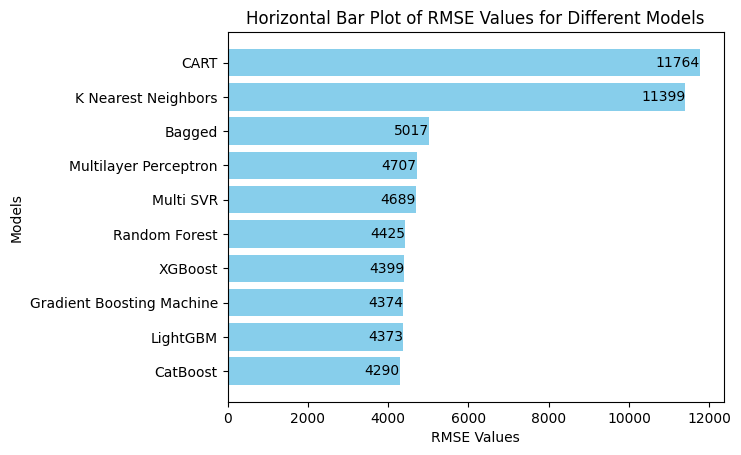

In [485]:
variables = ['Bagged', 'CART', 'CatBoost', 'Gradient Boosting Machine', 'K Nearest Neighbors', 'LightGBM', 'Multilayer Perceptron', 'Multi SVR', 'Random Forest', 'XGBoost']
values = [rmse_bagged, rmse_cart, rmse_catb, rmse_gbm, rmse_knn, rmse_lgbm, rmse_mlp, rmse_svr_tuned, rmse_rf, rmse_xgb]

# Değerleri sıralayarak indekslerini al
sorted_indexes = sorted(range(len(values)), key=lambda k: values[k])
sorted_variables = [variables[i] for i in sorted_indexes]
sorted_values = [values[i] for i in sorted_indexes]

plt.barh(sorted_variables, sorted_values, color='skyblue')

plt.xlabel('RMSE Values')
plt.ylabel('Models')
plt.title('Horizontal Bar Plot of RMSE Values for Different Models')

for i, value in enumerate(sorted_values):
    plt.text(value, i, f'{value:.0f}', ha='right', va='center')

plt.show()

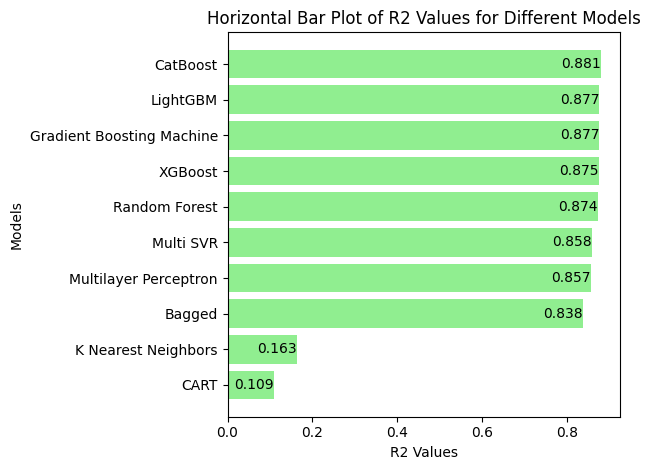

In [484]:
# List of model names
variables = ['Bagged', 'CART', 'CatBoost', 'Gradient Boosting Machine', 'K Nearest Neighbors', 'LightGBM', 'Multilayer Perceptron', 'Multi SVR', 'Random Forest', 'XGBoost']

# List of corresponding R2 values
values = [r2_bagged, r2_cart, r2_catb, r2_bgm, r2_knn, r2_lgbm, r2_mlp, r2_svr_tuned, r2_rf, r2_xgb]

# Sort the data based on R2 values
sorted_indexes = sorted(range(len(values)), key=lambda k: values[k])
sorted_variables = [variables[i] for i in sorted_indexes]
sorted_values = [values[i] for i in sorted_indexes]

# Plot horizontal bar chart
plt.barh(sorted_variables, sorted_values, color='lightgreen')

# Label x-axis
plt.xlabel('R2 Values')

# Label y-axis
plt.ylabel('Models')

# Title of the plot
plt.title('Horizontal Bar Plot of R2 Values for Different Models')

# Add R2 values as annotations
for i, value in enumerate(sorted_values):
    plt.text(value, i, f'{value:.3f}', ha='right', va='center')

# Display the plot
plt.tight_layout()
plt.show()

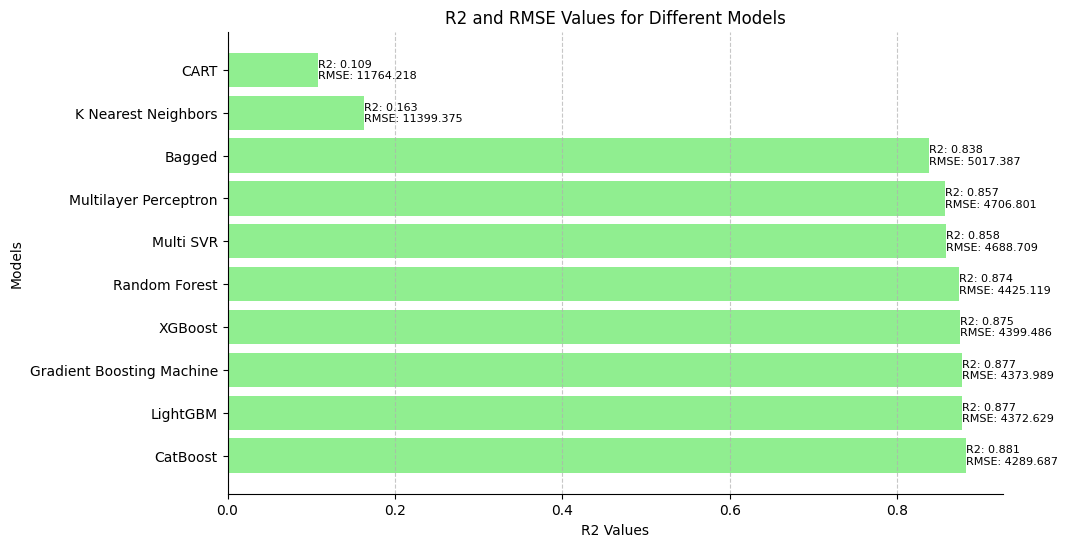

In [489]:
# List of model names
variables = ['Bagged', 'CART', 'CatBoost', 'Gradient Boosting Machine', 'K Nearest Neighbors', 'LightGBM', 'Multilayer Perceptron', 'Multi SVR', 'Random Forest', 'XGBoost']

# List of corresponding R2 values
r2_values = [r2_bagged, r2_cart, r2_catb, r2_bgm, r2_knn, r2_lgbm, r2_mlp, r2_svr_tuned, r2_rf, r2_xgb]

# List of corresponding RMSE values
rmse_values = [rmse_bagged, rmse_cart, rmse_catb, rmse_gbm, rmse_knn, rmse_lgbm, rmse_mlp, rmse_svr_tuned, rmse_rf, rmse_xgb]

# Sort the data based on R2 values
sorted_indexes = sorted(range(len(r2_values)), key=lambda k: r2_values[k])
sorted_variables = [variables[i] for i in sorted_indexes]
sorted_r2_values = [r2_values[i] for i in sorted_indexes]
sorted_rmse_values = [rmse_values[i] for i in sorted_indexes]

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for bars based on R2 values
colors = ['skyblue' if r2 < 0 else 'lightgreen' for r2 in sorted_r2_values]

# Plot horizontal bar chart with specified colors
bars = ax.barh(sorted_variables, sorted_r2_values, color=colors)

# Label x-axis
ax.set_xlabel('R2 Values')

# Label y-axis
ax.set_ylabel('Models')

# Title of the plot
ax.set_title('R2 and RMSE Values for Different Models')

# Add R2 values as annotations with improved alignment
for bar, r2_value, rmse_value in zip(bars, sorted_r2_values, sorted_rmse_values):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'R2: {r2_value:.3f}\nRMSE: {rmse_value:.3f}', ha='left', va='center', color='black', fontsize=8)

# Invert y-axis for descending order of models
ax.invert_yaxis()

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Remove spines (borders) from the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()


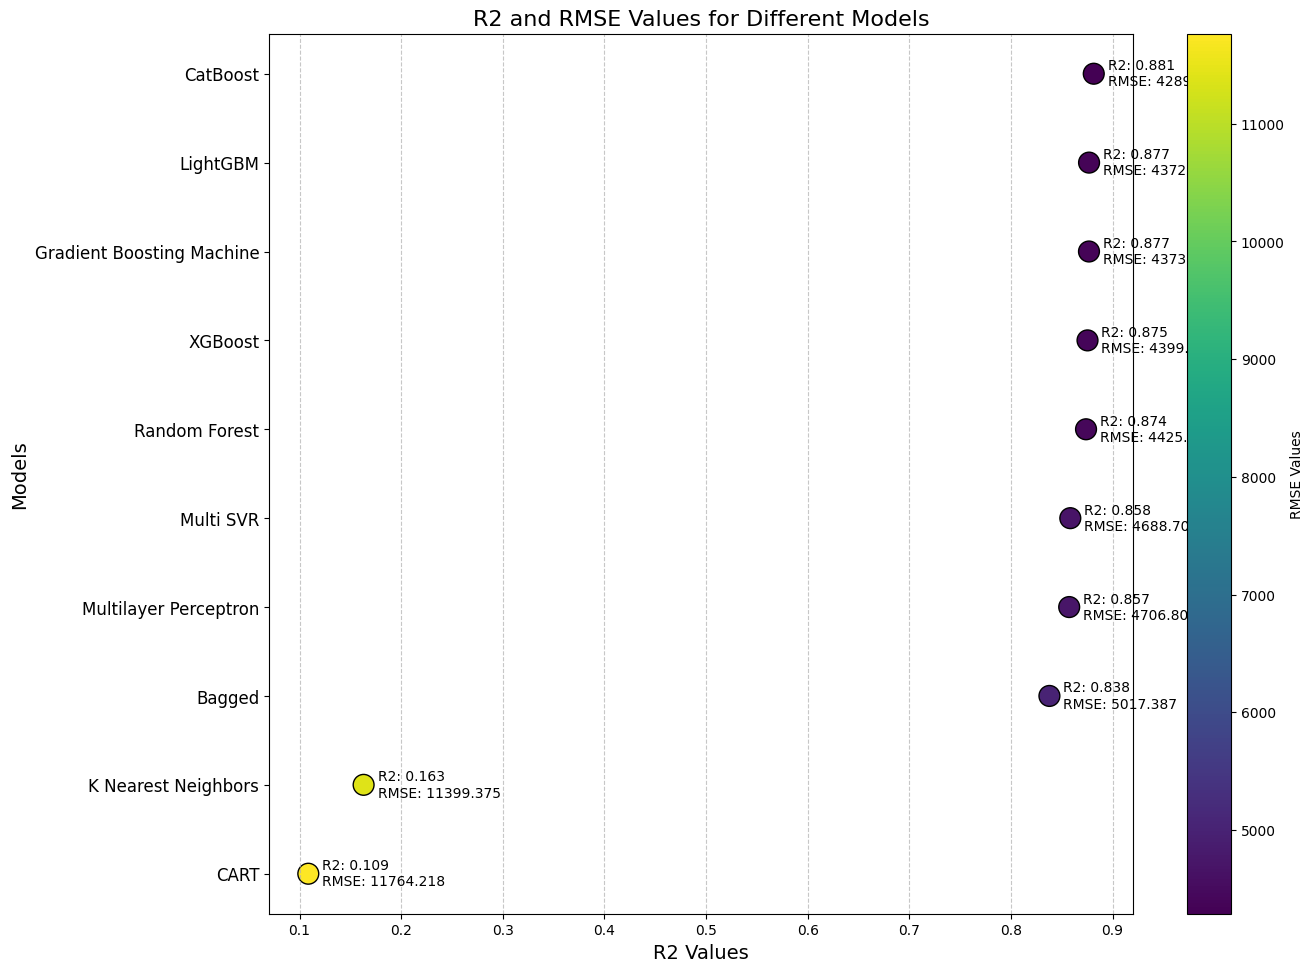

In [516]:
# List of model names
variables = ['Bagged', 'CART', 'CatBoost', 'Gradient Boosting Machine', 'K Nearest Neighbors', 'LightGBM', 'Multilayer Perceptron', 'Multi SVR', 'Random Forest', 'XGBoost']

# List of corresponding R2 values
r2_values = [r2_bagged, r2_cart, r2_catb, r2_bgm, r2_knn, r2_lgbm, r2_mlp, r2_svr_tuned, r2_rf, r2_xgb]

# List of corresponding RMSE values
rmse_values = [rmse_bagged, rmse_cart, rmse_catb, rmse_gbm, rmse_knn, rmse_lgbm, rmse_mlp, rmse_svr_tuned, rmse_rf, rmse_xgb]

# Sort the data based on R2 values
sorted_indexes = sorted(range(len(r2_values)), key=lambda k: r2_values[k])
sorted_variables = [variables[i] for i in sorted_indexes]
sorted_r2_values = [r2_values[i] for i in sorted_indexes]
sorted_rmse_values = [rmse_values[i] for i in sorted_indexes]

# Plot horizontal scatter plot with improved aesthetics and annotations for R2 and RMSE values
fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot with improved aesthetics
scatter = ax.scatter(sorted_r2_values, sorted_variables, c=sorted_rmse_values, cmap='viridis', s=150, edgecolors='black')

# Label y-axis with larger font
ax.set_ylabel('Models', fontsize=14)

# Label x-axis with larger font
ax.set_xlabel('R2 Values', fontsize=14)

# Title of the plot with larger font
ax.set_title('R2 and RMSE Values for Different Models', fontsize=16)

# Rotate y-axis labels for better readability
plt.yticks(fontsize=12)

# Increase marker size for better visibility
scatter.set_sizes([225])

# Annotate points with R2 values
for i, (r2, rmse) in enumerate(zip(sorted_r2_values, sorted_rmse_values)):
    ax.annotate(f'R2: {r2:.3f}\nRMSE: {rmse:.3f}', (sorted_r2_values[i], sorted_variables[i]), fontsize=10, ha='left', va='center', xytext=(10,0), textcoords=' offset points')

# Remove unnecessary spines (borders) from the plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from going outside the figure and move color bar away from the plot
plt.subplots_adjust(left=0.95, right=1.85, top=1.2, bottom=0.1)

# Add color bar legend with larger font and move it away from the plot
cbar = plt.colorbar(scatter)
cbar.set_label('RMSE Values', fontsize=10)
cbar.ax.yaxis.set_ticks_position('right')

# Show plot
#plt.tight_layout()  
plt.show()



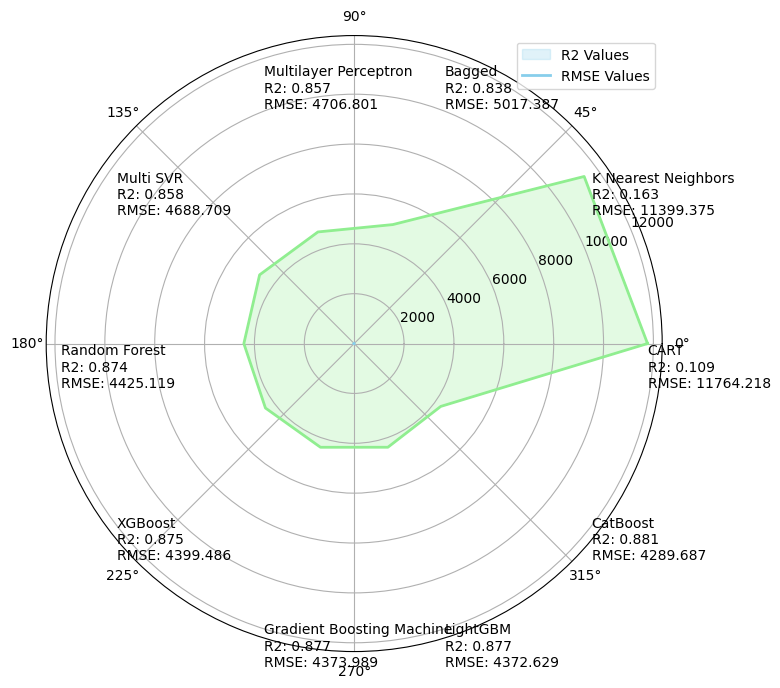

In [475]:
import numpy as np
import matplotlib.pyplot as plt

# List of model names
variables = ['Bagged', 'CART', 'CatBoost', 'Gradient Boosting Machine', 'K Nearest Neighbors', 'LightGBM', 'Multilayer Perceptron', 'Multi SVR', 'Random Forest', 'XGBoost']

# List of corresponding R2 values
r2_values = [r2_bagged, r2_cart, r2_catb, r2_gbm, r2_knn, r2_lgbm, r2_mlp, r2_svr_tuned, r2_rf, r2_xgb]

# List of corresponding RMSE values
rmse_values = [rmse_bagged, rmse_cart, rmse_catb, rmse_gbm, rmse_knn, rmse_lgbm, rmse_mlp, rmse_svr_tuned, rmse_rf, rmse_xgb]

# Sort the data based on R2 values
sorted_indexes = sorted(range(len(r2_values)), key=lambda k: r2_values[k])
sorted_variables = [variables[i] for i in sorted_indexes]
sorted_r2_values = [r2_values[i] for i in sorted_indexes]
sorted_rmse_values = [rmse_values[i] for i in sorted_indexes]

# Number of models
num_models = len(sorted_variables)

# Define angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_models, endpoint=False).tolist()

# The radar chart is circular, so we need to "complete the loop" and append the start to the end.
sorted_r2_values += sorted_r2_values[:1]
sorted_rmse_values += sorted_rmse_values[:1]
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, sorted_r2_values, color='skyblue', alpha=0.25)
ax.plot(angles, sorted_r2_values, color='skyblue', linewidth=2, linestyle='solid')
ax.fill(angles, sorted_rmse_values, color='lightgreen', alpha=0.25)
ax.plot(angles, sorted_rmse_values, color='lightgreen', linewidth=2, linestyle='solid')

# Label each point on the radar chart
for angle, r2_value, rmse_value, variable in zip(angles, sorted_r2_values, sorted_rmse_values, sorted_variables):
    ax.text(angle, max(max(sorted_r2_values), max(sorted_rmse_values)), f'{variable}\nR2: {r2_value:.3f}\nRMSE: {rmse_value:.3f}', ha='left', va='top')

# Add legend
ax.legend(['R2 Values', 'RMSE Values'], loc='upper right')

# Show plot
plt.show()
